# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S12

## Experimental measurements

In [2]:
import pandas as pd
bindingvars = pd.read_csv(path+"Fig7/FYN_bPCA_fitness_replicates.txt",
                         sep='\t', lineterminator='\n', low_memory=False)

bindingvars = bindingvars.sort_values('fitness', ascending=False)

FYN_core_seq = 'FLFFIIV'
FYN_core_pos = [2,16,18,24,26,48,53]

for index, row in bindingvars.iterrows():
    core=[]
    for i in FYN_core_pos:
        core.append(row.aa_seq[i])
    bindingvars.at[index,'core'] = ''.join(core)
    
    if core == FYN_core_seq:
        bindingvars.at[index, 'Nham_aa'] = 0
    else:
        bindingvars.at[index, 'Nham_aa'] = sum(1 for a,b in zip(FYN_core_seq, core) if a!=b)

In [3]:
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

bindingvars_scaled = bindingvars.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

def normalize_errors(values, bounds):
    return [x * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=bindingvars, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

bindingvars_scaled['fitness']=normalize(list(bindingvars_scaled['fitness']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma']=normalize_errors(list(bindingvars_scaled['sigma']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['fitness1_uncorr']=normalize(list(bindingvars_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma1_uncorr']=normalize_errors(list(bindingvars_scaled['sigma1_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['fitness2_uncorr']=normalize(list(bindingvars_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma2_uncorr']=normalize_errors(list(bindingvars_scaled['sigma2_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['fitness3_uncorr']=normalize(list(bindingvars_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness3_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
bindingvars_scaled['sigma3_uncorr']=normalize_errors(list(bindingvars_scaled['sigma3_uncorr']),{'actual': {'lower': mode, 'upper': bindingvars_scaled.loc[bindingvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})

fig, ax = plt.subplots()

my_kde = kdeplot(data=bindingvars_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

In [4]:
# Load data

import pandas as pd
from Bio.Seq import Seq

stabilityvars = pd.read_csv(path+"Fig1/Sparse_DTS_Cores_fitness_replicates.txt",
                         sep='\t', lineterminator='\n', low_memory=False)

stabilityvars = stabilityvars.sort_values('fitness', ascending = False)

# De-multiplex each protein's variants

ID_dict =  {'MT' : 'P0A9X9',
           'KT' : 'P01053',
           'TL' : 'P06241'}

for index, row in stabilityvars.iterrows():
    try:
        stabilityvars.at[index,'Protein']=ID_dict[row.aa_seq[:2]]
    except KeyError:
        continue

stabilityvars = stabilityvars.loc[stabilityvars['Protein']=='P06241'].copy()

# Find core sequences

cores = {'P06241' : [2,16,18,24,26,48,53]}

for index, row in stabilityvars.iterrows():
    core=[]
    for i in cores[row.Protein]:
        core.append(row.aa_seq[i])
    stabilityvars.at[index,'core'] = ''.join(core)

# Define WT cores

proteins = {'P06241': 'FYN-SH3'}

P06241 = 'ACGCTTTTCGTTGCATTGTATGATTATGAAGCAAGAACTGAAGATGATTTGTCTTTCCATAAAGGTGAAAAATTCCAAATCTTGAATTCTTCTGAAGGTGATTGGTGGGAAGCAAGATCTTTGACTACTGGTGAAACTGGTTATATCCCATCTAACTATGTCGCGCCTGTG'

prots=[P06241]

wt_cores = {}
for (prot_seq, prot_nam) in zip(prots, proteins.keys()):
    aa_seq=str(Seq(prot_seq).translate())
    wt_core=[]
    for i in cores[prot_nam]:
        wt_core.append(aa_seq[i])
    wt_cores[prot_nam]= ''.join(wt_core)

# Find Hamming distance to WT

for index, row in stabilityvars.iterrows():
    wt = wt_cores[row.Protein]
    stabilityvars.at[index, 'wt_core']=wt
    if row.core == wt:
        stabilityvars.at[index, 'Nham_aa'] = 0
    else:
        stabilityvars.at[index, 'Nham_aa'] = sum(1 for a,b in zip(wt, row.core) if a!=b)

In [5]:
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

stabilityvars_scaled = stabilityvars.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

def normalize_errors(values, bounds):
    return [x * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=stabilityvars, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

stabilityvars_scaled['fitness']=normalize(list(stabilityvars_scaled['fitness']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['sigma']=normalize_errors(list(stabilityvars_scaled['sigma']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['fitness1_uncorr']=normalize(list(stabilityvars_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['sigma1_uncorr']=normalize_errors(list(stabilityvars_scaled['sigma1_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['fitness2_uncorr']=normalize(list(stabilityvars_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
stabilityvars_scaled['sigma2_uncorr']=normalize_errors(list(stabilityvars_scaled['sigma2_uncorr']),{'actual': {'lower': mode, 'upper': stabilityvars_scaled.loc[stabilityvars_scaled['core']==arbitraryWT]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})

fig, ax = plt.subplots()

my_kde = kdeplot(data=stabilityvars_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

In [6]:
bindingvars_scaled = bindingvars_scaled.rename(columns={'fitness': 'binding_fitness'})
stabilityvars_scaled = stabilityvars_scaled.rename(columns={'fitness': 'stability_fitness'})
stability_vs_binding_scaled = bindingvars_scaled.merge(stabilityvars_scaled, left_on='aa_seq', right_on='aa_seq')

In [7]:
columns = ['Query','Target','E-value','SeqId','QueryStart', 'QueryEnd','QueryLen', 'TargetStart',
          'TargetEnd','TargetLen', 'Align_len', 'Score', 'QuerySeq', 'TargetSeq', 'mismatch',
           'QueryCov','TargetCov', 'taxid','taxname','taxlineage','lddt','alntmscore','rmsd','prob']

isofolds=pd.read_csv(path+'Fig5/fyn_aln1_AFUniprot',names=columns,sep='\t')

reliable_isofolds = isofolds.loc[isofolds['alntmscore']>0.6].loc[isofolds['prob']==1].loc[isofolds['QueryStart']<3].loc[isofolds['QueryEnd']>53].loc[isofolds['rmsd']<2].drop_duplicates('TargetSeq').copy()

#allDTS core finding

DTS=['F','L','I','M','V']

wt=reliable_isofolds.iloc[0]['QuerySeq']
mut_pos = [2,16,18,24,26,48,53]
wtcore=''.join([reliable_isofolds.iloc[0]['QuerySeq'][i] for i in mut_pos])

aatype_pos=[]
for i in mut_pos:
    aatyperange=0
    for res in wt[:i]:
        if res == wt[i-1]:
            aatyperange+=1
    aatype_pos.append(aatyperange)
    
totalerrors=0
for index, row in reliable_isofolds.iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    target_mut_pos=[]
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
        
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    mut_pos_test = [x+1 - row.QueryStart for x in mut_pos]
    mut=[]
    for pos in mut_pos_test:
        try:
            mut.append(aligned_target[pos])
        except IndexError:
            totalerrors+=1
        
    if ''.join(mut) == wtcore:
        reliable_isofolds.at[index,'WTcore']=True
        reliable_isofolds.at[index,'Nham']=0
    else:
        reliable_isofolds.at[index,'WTcore']=False
        nham=0
        for mutres, wtres in zip(mut,wtcore):
            if mutres != wtres:
                nham+=1
        reliable_isofolds.at[index,'Nham']=nham
        
    reliable_isofolds.at[index,'MutCore']=('').join(mut)
    allDTS=True
    coreDels=False
    for res in mut:
        if res not in DTS:
            allDTS=False
        if res == '-':
            coreDels=True
    reliable_isofolds.at[index,'allDTS']=allDTS
    reliable_isofolds.at[index,'coreDels']=coreDels  

natural_cores_stb_bin = stability_vs_binding_scaled[stability_vs_binding_scaled['core_y'].isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True]['MutCore'].unique()))].copy()

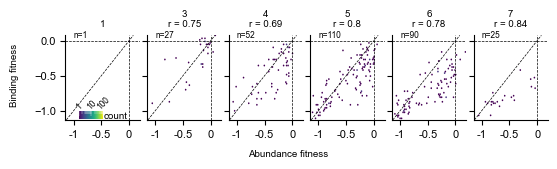

In [8]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
from decimal import Decimal
import math
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial'

xlim=(min(natural_cores_stb_bin['stability_fitness']),max(natural_cores_stb_bin['stability_fitness']))
ylim=(min(natural_cores_stb_bin['binding_fitness']),max(natural_cores_stb_bin['binding_fitness']))

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(5.5,1.6))
coliterator=0
rowiterator=0
for hamm_dist in [1,3,4,5,6,7]:
    #natural_cores_stb_bin.loc[natural_cores_stb_bin['Nham_aa_x']==hamm_dist].plot.scatter(y='stability_fitness', x='binding_fitness')
    
    y = natural_cores_stb_bin.loc[natural_cores_stb_bin['Nham_aa_x']==hamm_dist][['binding_fitness']].to_numpy()
    x = natural_cores_stb_bin.loc[natural_cores_stb_bin['Nham_aa_x']==hamm_dist][['stability_fitness']].to_numpy()
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=100, rasterized=True,linewidths=0, extent=[min(natural_cores_stb_bin['stability_fitness']),max(natural_cores_stb_bin['stability_fitness']),min(natural_cores_stb_bin['binding_fitness']),max(natural_cores_stb_bin['binding_fitness'])])
    
    if hamm_dist > 1:
        model = LinearRegression()
        model.fit(x,y)
        
        y_pred = model.predict(x)
        
        ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    else:
        ax[coliterator].set_title(str(hamm_dist), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(natural_cores_stb_bin['binding_fitness']),max(natural_cores_stb_bin['binding_fitness']))
    ax[coliterator].set_xlim(min(natural_cores_stb_bin['stability_fitness']),max(natural_cores_stb_bin['stability_fitness']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks(np.arange(-1,0.1,0.5), [Decimal(i).normalize() for i in np.arange(-1,0.1,0.5)],fontsize=6)
    #ax[coliterator].set_xticklabels([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    ax[coliterator].annotate('n='+f"{len(x):,}", (-1,0.05), fontsize=6)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1

fmt = '%1.f'
cax=fig.add_axes([0.12,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
cb.set_ticks([1,10,100])
cb.set_ticklabels([1,10,100], fontsize=6, rotation=45)
ax1 = cb.ax
ax1.text(110,0.1,'count',rotation=0, fontsize=7)


fig.text(0.5, -0.015, 'Abundance fitness', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Binding fitness', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_vs_stability_measured_core_transplant_fitness.svg', dpi=300, transparent=True, bbox_inches='tight')

## 1st order model predictions

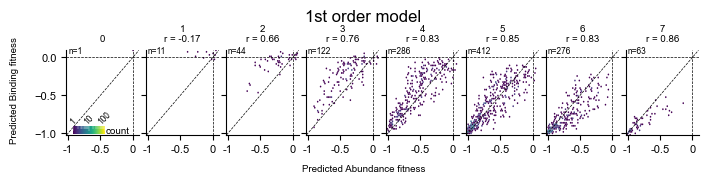

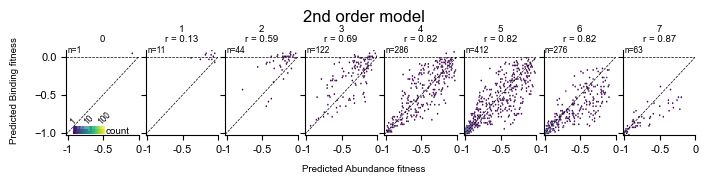

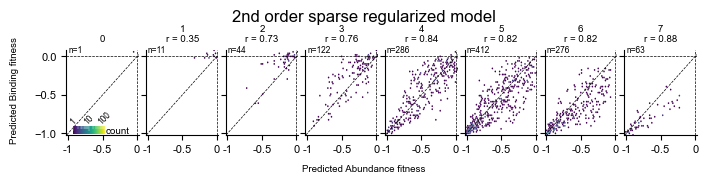

In [9]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math
from decimal import Decimal
from seaborn import kdeplot
import warnings
warnings.filterwarnings('ignore')

for model_name, task, model_name_print in zip(['1', '2', '2_sparseregularized'], ['1','1','4'], ['1st order model', '2nd order model', '2nd order sparse regularized model']):
    
    # Load data
    
    full_landscape = pd.read_csv(path+'Fig7'+'/FYN_coreDTS_bPCA_order'+model_name+'/task_'+task+'/predictions/predicted_phenotypes_supp.txt',
                                sep='\t', low_memory = False)
    
    FYN_core_seq = 'FLFFIIV'
    FYN_core_pos = [2,16,18,24,26,48,53]
    
    for index, row in full_landscape.iterrows():
        core=[]
        for i in FYN_core_pos:
            core.append(row.aa_seq[i])
        full_landscape.at[index,'core'] = ''.join(core)
        
        if core == FYN_core_seq:
            full_landscape.at[index, 'Nham_aa_core'] = 0
        else:
            full_landscape.at[index, 'Nham_aa_core'] = sum(1 for a,b in zip(FYN_core_seq, core) if a!=b)
    
    full_landscape_abundance = full_landscape.loc[full_landscape['Abundance']==1].copy()
    full_landscape_abundance['mean'] = full_landscape_abundance[['fold_'+str(i) for i in range(1,11,1)]].mean(axis=1)
    full_landscape_abundance['std'] =  full_landscape_abundance[['fold_'+str(i) for i in range(1,11,1)]].std(axis=1)
    full_landscape_binding =   full_landscape.loc[full_landscape['Binding']==1].copy()
    full_landscape_binding['mean'] = full_landscape_binding[['fold_'+str(i) for i in range(1,11,1)]].mean(axis=1)
    full_landscape_binding['std'] =  full_landscape_binding[['fold_'+str(i) for i in range(1,11,1)]].std(axis=1)
    
    # Normalize data
    
    predicted_abundance_scaled = full_landscape_abundance.copy()
    predicted_binding_scaled = full_landscape_binding.copy()
    
    def normalize(values, bounds):
        return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]
    
    # Normalize abundance fitness predictions
    
    fig, ax = plt.subplots()
    
    my_kde = kdeplot(data=full_landscape_abundance, x='mean', ax=ax)
    
    lines = my_kde.get_lines()
    plt.close()
    for line in lines:
        x, y = line.get_data()
        mode=(x[np.argmax(y)])
    
    
    predicted_abundance_scaled['mean']=        normalize(list(predicted_abundance_scaled['mean']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
    
    # Normalize binding fitness predictions
    
    fig, ax = plt.subplots()
    
    my_kde = kdeplot(data=full_landscape_binding, x='mean', ax=ax)
    
    lines = my_kde.get_lines()
    plt.close()
    for line in lines:
        x, y = line.get_data()
        mode=(x[np.argmax(y)])
    
    
    predicted_binding_scaled['mean']=        normalize(list(predicted_binding_scaled['mean']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
    
    # Merge data
    
    predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'mean': 'predicted_stability_fitness'})
    predicted_binding_scaled = predicted_binding_scaled.rename(columns={'mean': 'predicted_binding_fitness'})
    predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'fitness': 'stability_fitness'})
    predicted_binding_scaled = predicted_binding_scaled.rename(columns={'fitness': 'binding_fitness'})
    predicted_stability_vs_binding = predicted_binding_scaled.merge(predicted_abundance_scaled, left_on='aa_seq', right_on='aa_seq')
    
    # Filter for core configurations in structural homolog set and plot
    
    natural_cores_stb_bin = predicted_stability_vs_binding[predicted_stability_vs_binding['core_y'].isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True]['MutCore'].unique()))].copy()
    
    
    
    plt.rcParams['font.family'] = 'Arial'
    
    xlim=(min(natural_cores_stb_bin['predicted_stability_fitness']),max(natural_cores_stb_bin['predicted_stability_fitness']))
    ylim=(min(natural_cores_stb_bin['predicted_binding_fitness']),max(natural_cores_stb_bin['predicted_binding_fitness']))
    
    fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(7,1.6))
    coliterator=0
    rowiterator=0
    for hamm_dist in range(0,8,1):
        #natural_cores_stb_bin.loc[natural_cores_stb_bin['Nham_aa_x']==hamm_dist].plot.scatter(y='stability_fitness', x='binding_fitness')
        
        y = natural_cores_stb_bin.loc[natural_cores_stb_bin['Nham_aa_x']==hamm_dist][['predicted_binding_fitness']].to_numpy()
        x = natural_cores_stb_bin.loc[natural_cores_stb_bin['Nham_aa_x']==hamm_dist][['predicted_stability_fitness']].to_numpy()
        
        ax[coliterator].set(xlim=xlim,ylim=ylim)
        hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=100, rasterized=True,linewidths=0, extent=[min(natural_cores_stb_bin['predicted_stability_fitness']),max(natural_cores_stb_bin['predicted_stability_fitness']),min(natural_cores_stb_bin['predicted_binding_fitness']),max(natural_cores_stb_bin['predicted_binding_fitness'])])
        
        if hamm_dist > 0:
            model = LinearRegression()
            model.fit(x,y)
            
            y_pred = model.predict(x)
            
            ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
        else:
            ax[coliterator].set_title(str(hamm_dist), fontsize=7)
        ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
        ax[coliterator].set_ylim(min(natural_cores_stb_bin['predicted_binding_fitness']),max(natural_cores_stb_bin['predicted_binding_fitness']))
        ax[coliterator].set_xlim(min(natural_cores_stb_bin['predicted_stability_fitness']),max(natural_cores_stb_bin['predicted_stability_fitness']))
        ax[coliterator].spines[['right','top']].set_visible(False)
        ax[coliterator].set_xticks([0,-0.5,-1])
        ax[coliterator].set_xticks(np.arange(-1,0.1,0.5), [Decimal(i).normalize() for i in np.arange(-1,0.1,0.5)],fontsize=6)
        #ax[coliterator].set_xticklabels([0,-0.5,-1])
        ax[coliterator].tick_params(axis='x', labelsize=8)
        ax[coliterator].tick_params(axis='y', labelsize=8)
        ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
        ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
        ax[coliterator].set_rasterization_zorder(0)
        ax[coliterator].annotate('n='+f"{len(x):,}", (-1,0.05), fontsize=6)
        if coliterator != 0:
            ax[coliterator].yaxis.set_ticklabels([])
        coliterator+=1
        
    #fmt = '%1.f'
    #cax=fig.add_axes([0.99,0.25,0.005,0.3])
    #cb=fig.colorbar(hbin, shrink=0.7,format=fmt,cax=cax)
    #cb.ax.set_title('Counts',fontsize=7)
    ##cb.set_label('counts', rotation=270, fontsize=7, labelpad=8)
    #cb.set_ticks([1,5,10,50])
    #cb.set_ticklabels([1,5,10,50], fontsize=6)
    
    fmt = '%1.f'
    cax=fig.add_axes([0.085,0.22,0.045,0.05])
    cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
    cb.outline.set_visible(False)
    cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
    cb.ax.xaxis.set_tick_params(pad=0)
    #cb.ax.set_title('Count', fontsize=7)
    #cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
    #cb.ax.xaxis.set_label_position('right')
    cb.set_ticks([1,10,100])
    cb.set_ticklabels([1,10,100], fontsize=6, rotation=45)
    ax1 = cb.ax
    ax1.text(110,0.1,'count',rotation=0, fontsize=7)
    
    
    fig.text(0.5, -0.015, 'Predicted Abundance fitness', ha='center', fontsize=7)
    fig.text(-0.005, 0.5, 'Predicted Binding fitness', va='center', rotation='vertical', fontsize=7)
    fig.tight_layout()
    fig.suptitle(model_name_print, y=1)
    plt.subplots_adjust(wspace=0.1)
    plt.rcParams['svg.fonttype'] = 'none'
    #plt.savefig('FYN_binding_vs_stability_1storder3statemodel_predicted_fitness_allcoretransplants_from_fulllandscape.svg', dpi=300, transparent=True, bbox_inches='tight')